In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/wenbo/Desktop/tongxue
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-26 06:09:07,359 INFO: Initializing external client
2025-11-26 06:09:07,359 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-26 06:09:08,825 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1303706


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])


#selected_features = (
 #   air_quality_fg.select(['pm25', 'date', 'city'])
  #  .join(weather_fg.select_all(), on=['city', 'date'])
#)


df_preview = selected_features.read()
df_preview.head()


2025-11-26 06:09:11,354 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,56.0,2018-08-25 00:00:00+00:00,26.599497,9.3,20.380579,55.271492
1,39.0,2018-08-26 00:00:00+00:00,27.584915,10.9,18.511143,156.697311
2,30.0,2018-08-27 00:00:00+00:00,28.470335,1.0,26.144030,143.732391
3,25.0,2018-08-28 00:00:00+00:00,28.257833,0.1,25.284714,146.960068
4,36.0,2018-08-29 00:00:00+00:00,28.457832,0.6,21.533897,152.944778


In [6]:
df = selected_features.read() 
print("rows:", len(df))


uniq = df.groupby(['date']).size().sort_values(ascending=False).head(10)
print(uniq) 

df2 = (
    air_quality_fg.select(['pm25','date','city'])
    .join(weather_fg.select_features(), on=['city'])
).read()
dup = df2.groupby(['city','date']).size().sort_values(ascending=False).head(10)
print(dup)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 
rows: 2543
date
2018-08-25 00:00:00+00:00    1
2023-07-27 00:00:00+00:00    1
2023-07-20 00:00:00+00:00    1
2023-07-21 00:00:00+00:00    1
2023-07-22 00:00:00+00:00    1
2023-07-23 00:00:00+00:00    1
2023-07-24 00:00:00+00:00    1
2023-07-25 00:00:00+00:00    1
2023-07-26 00:00:00+00:00    1
2023-07-28 00:00:00+00:00    1
dtype: int64
2025-11-26 06:09:17,396 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
city      date                     
shanghai  2018-08-25 00:00:00+00:00    1
          2023-07-27 00:00:00+00:00    1
          2023-07-20 00:00:00+00:00    1
          2023-07-21 00:00:00+00:00    1
          2023-07-22 00:00:00+00:00    1
  

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [7]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [8]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.51s) 


In [10]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2018-08-25 00:00:00+00:00,26.599497,9.3,20.380579,55.271492
1,2018-08-26 00:00:00+00:00,27.584915,10.9,18.511143,156.697311
2,2018-08-27 00:00:00+00:00,28.470335,1.0,26.144030,143.732391
3,2018-08-28 00:00:00+00:00,28.257833,0.1,25.284714,146.960068
4,2018-08-29 00:00:00+00:00,28.457832,0.6,21.533897,152.944778
...,...,...,...,...,...
2335,2025-04-26 00:00:00+00:00,18.068249,0.0,14.926983,137.998154
2336,2025-04-27 00:00:00+00:00,19.870335,0.1,17.371632,233.130005
2337,2025-04-28 00:00:00+00:00,18.309916,0.0,12.886039,27.571960
2338,2025-04-29 00:00:00+00:00,21.253664,0.0,14.822429,159.035202


In [11]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [12]:
y_train

,pm25
0,56.0
1,39.0
2,30.0
3,25.0
4,36.0
...,...
2335,60.0
2336,58.0
2337,80.0
2338,81.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 980.04974
R squared: -0.4121865605276873


In [15]:
df = y_test
df['predicted_pm25'] = y_pred

In [16]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
2340,90.0,57.023853,2025-05-01 00:00:00+00:00
2341,101.0,84.933563,2025-05-02 00:00:00+00:00
2342,76.0,63.817989,2025-05-03 00:00:00+00:00
2343,40.0,80.266533,2025-05-04 00:00:00+00:00
2344,66.0,66.017853,2025-05-05 00:00:00+00:00


In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

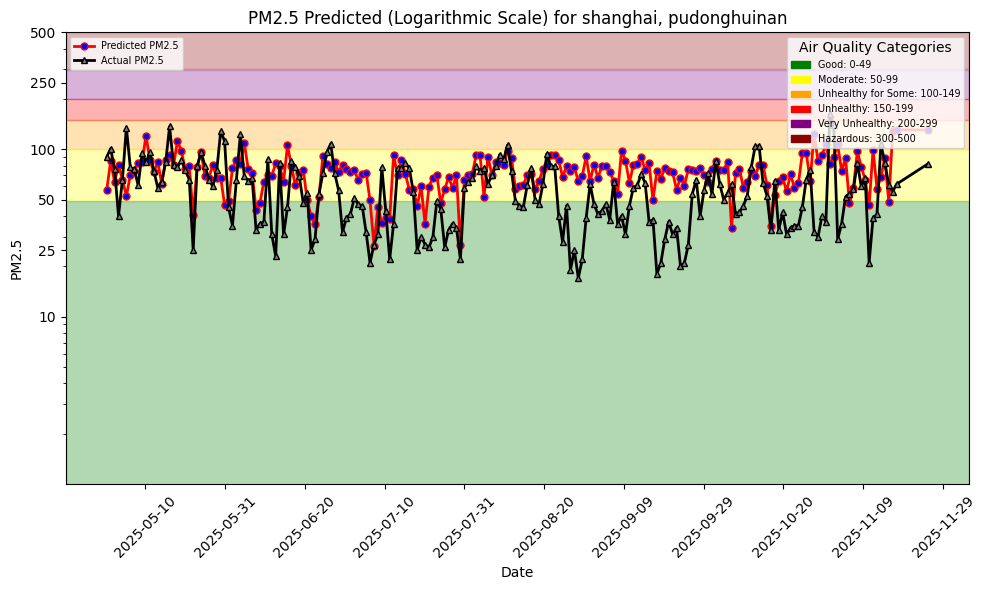

In [18]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

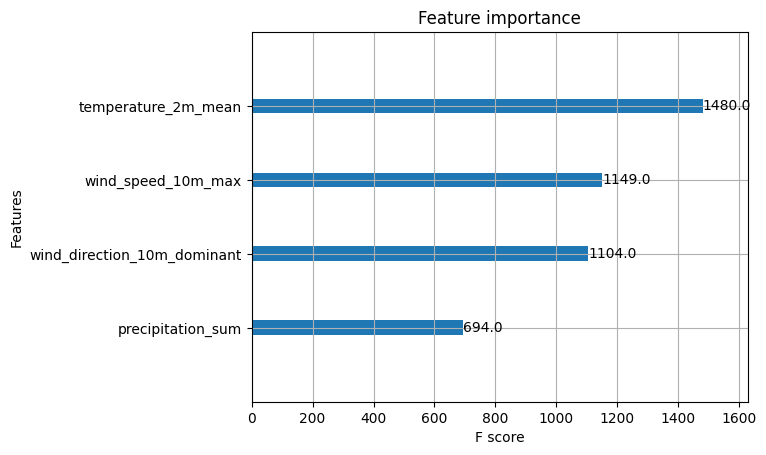

In [19]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [20]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [21]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [22]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0…

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model/.DS_Store: 0.000%|          | 0/…

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model/images/.DS_Store: 0.000%|       …

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model/images/feature_importance.png: 0…

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%…

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/model_schema.json: 0.000%|          | 0/572 elapse…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1303706/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)

# Grade ‘C’ tasks

In [23]:
# Retrieve the air quality feature group (version 2)
air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)

# Retrieve the weather feature group (version 1)
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)

# Select specific columns from the air quality feature group (including lag features)
aq_sel_v2 = air_quality_fg_v2.select([
    "pm25",
    "date",
    "pm25_lag1",
    "pm25_lag2",
    "pm25_lag3",
])

# Select all features from the weather feature group
wx_sel = weather_fg.select_features()

# Join air quality and weather features on the "city" key
selected_features_v2 = aq_sel_v2.join(
    wx_sel,
    on=["city"],
)

# Read the joined feature data into a DataFrame
df_v2 = selected_features_v2.read()
print(df_v2.head())

# Create or get a feature view that includes:
# - pm25 as the label
# - lagged pm25 and weather features
# - using the combined feature query (selected_features_v2)
feature_view_v2 = fs.get_or_create_feature_view(
    name="air_quality_fv",
    description="air_quality v2 with lagged pm25 + weather features; pm25 as target",
    version=2,
    labels=["pm25"],
    query=selected_features_v2,
)


2025-11-26 06:09:51,280 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 
   pm25                      date  pm25_lag1  pm25_lag2  pm25_lag3  \
0  25.0 2018-08-28 00:00:00+00:00       30.0       39.0       56.0   
1  36.0 2018-08-29 00:00:00+00:00       25.0       30.0       39.0   
2  42.0 2018-08-30 00:00:00+00:00       36.0       25.0       30.0   
3  44.0 2018-08-31 00:00:00+00:00       42.0       36.0       25.0   
4  94.0 2018-09-01 00:00:00+00:00       44.0       42.0       36.0   

   temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0            28.257833                0.1           25.284714   
1            28.457832                0.6           21.533897   
2            28.553667                0.1           

In [24]:
# Define the start date for the test dataset
start_date_test_data = "2025-05-01"

# Convert the string date into a Python datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

# Perform a train/test split using the custom 'feature_view_v2' method
# The split uses 'test_start' to determine which rows belong to the test set
X_train_2, X_test_2, y_train_2, y_test_2 = feature_view_v2.train_test_split(
    test_start=test_start
)

# Print all column names in the training feature set
print("All column names in the current X_train_2:", X_train_2.columns)

# Remove the 'date' column from the training and test feature datasets
X_features_2 = X_train_2.drop(columns=["date"])
X_test_features_2 = X_test_2.drop(columns=["date"])


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 
All column names in the current X_train_2: Index(['date', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'temperature_2m_mean',
       'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant'],
      dtype='object')


In [25]:
X_train_2

,date,pm25_lag1,pm25_lag2,pm25_lag3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2018-08-28 00:00:00+00:00,30.0,39.0,56.0,28.257833,0.1,25.284714,146.960068
1,2018-08-29 00:00:00+00:00,25.0,30.0,39.0,28.457832,0.6,21.533897,152.944778
2,2018-08-30 00:00:00+00:00,36.0,25.0,30.0,28.553667,0.1,23.838961,164.508194
3,2018-08-31 00:00:00+00:00,42.0,36.0,25.0,27.659914,6.0,14.707222,225.214600
4,2018-09-01 00:00:00+00:00,44.0,42.0,36.0,27.162003,4.5,11.200571,31.134464
...,...,...,...,...,...,...,...,...
2332,2025-04-26 00:00:00+00:00,71.0,153.0,124.0,18.068249,0.0,14.926983,137.998154
2333,2025-04-27 00:00:00+00:00,60.0,71.0,153.0,19.870335,0.1,17.371632,233.130005
2334,2025-04-28 00:00:00+00:00,58.0,60.0,71.0,18.309916,0.0,12.886039,27.571960
2335,2025-04-29 00:00:00+00:00,80.0,58.0,60.0,21.253664,0.0,14.822429,159.035202


In [26]:
y_train_2

,pm25
0,25.0
1,36.0
2,42.0
3,44.0
4,94.0
...,...
2332,60.0
2333,58.0
2334,80.0
2335,81.0


In [27]:
#X_test_2

In [28]:
#y_test_2

In [29]:
X_features_2

,pm25_lag1,pm25_lag2,pm25_lag3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,30.0,39.0,56.0,28.257833,0.1,25.284714,146.960068
1,25.0,30.0,39.0,28.457832,0.6,21.533897,152.944778
2,36.0,25.0,30.0,28.553667,0.1,23.838961,164.508194
3,42.0,36.0,25.0,27.659914,6.0,14.707222,225.214600
4,44.0,42.0,36.0,27.162003,4.5,11.200571,31.134464
...,...,...,...,...,...,...,...
2332,71.0,153.0,124.0,18.068249,0.0,14.926983,137.998154
2333,60.0,71.0,153.0,19.870335,0.1,17.371632,233.130005
2334,58.0,60.0,71.0,18.309916,0.0,12.886039,27.571960
2335,80.0,58.0,60.0,21.253664,0.0,14.822429,159.035202


In [30]:
X_test_features_2

,pm25_lag1,pm25_lag2,pm25_lag3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
2337,60.0,81.0,80.0,22.080751,1.4,22.309835,342.968811
2338,90.0,60.0,81.0,23.214083,0.0,16.985933,164.332123
2339,101.0,90.0,60.0,19.228666,0.0,19.959719,22.422531
2340,76.0,101.0,90.0,18.499502,0.9,15.627897,125.861038
2341,40.0,76.0,101.0,18.903667,2.5,18.758902,255.991974
...,...,...,...,...,...,...,...
2535,108.0,41.0,39.0,16.122416,0.0,9.531505,101.325867
2536,83.0,108.0,41.0,18.795334,0.8,17.589418,42.334049
2537,61.0,83.0,108.0,9.332833,0.7,23.597170,342.707458
2538,56.0,61.0,83.0,6.259916,0.0,15.275627,312.703583


In [31]:
# Create an XGBoost regressor model
xgb_regressor_2 = XGBRegressor()

# Train the model using training features and target values
xgb_regressor_2.fit(X_features_2, y_train_2)

# Use the trained model to make predictions on the test set
y_pred_2 = xgb_regressor_2.predict(X_test_features_2)

# Calculate Mean Squared Error (MSE) between true and predicted values
mse_2 = mean_squared_error(y_test_2.iloc[:, 0], y_pred_2)
print("MSE:", mse_2)

# Calculate R-squared (R²) score to evaluate model performance
r2_2 = r2_score(y_test_2.iloc[:, 0], y_pred_2)
print("R squared:", r2_2)


MSE: 679.3747
R squared: 0.02106622762208754


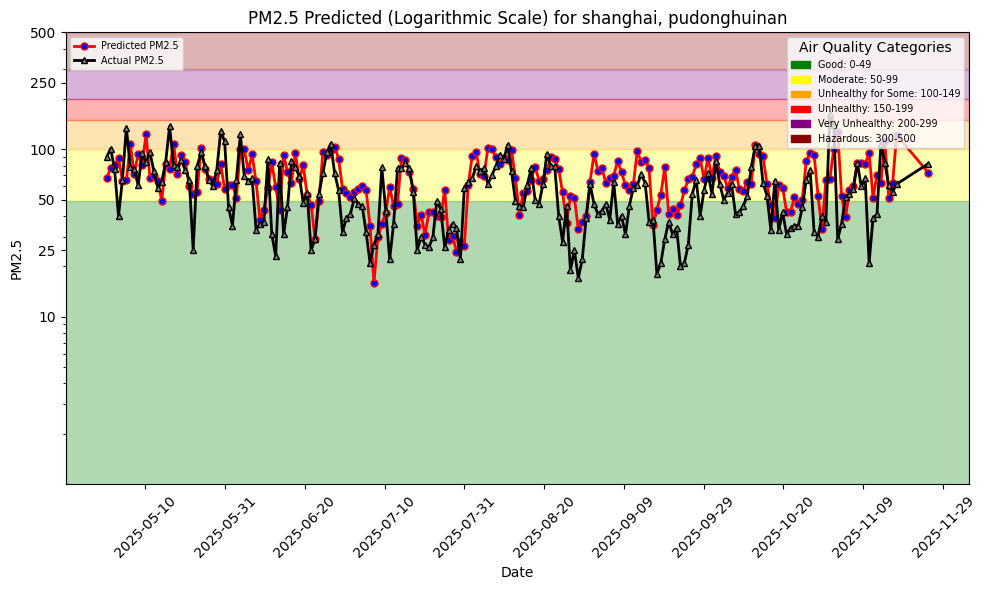

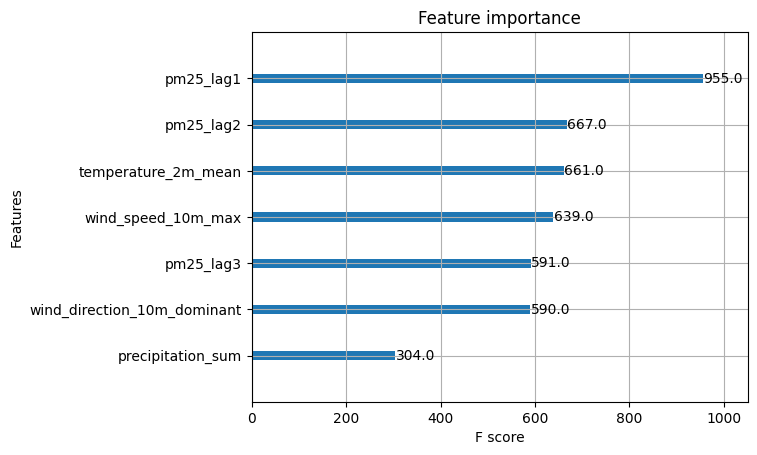

In [32]:
# Copy the true test values for PM2.5 into a new DataFrame
df_2 = y_test_2

# Add a new column for the predicted PM2.5 values
df_2['predicted_pm25'] = y_pred_2

# Add the corresponding date column from the test features
df_2['date'] = X_test_2['date']

# Sort the DataFrame by date for chronological order
df_2 = df_2.sort_values(by=['date'])

# Display the first 5 rows to check the data
df_2.head(5)


# Define the directory to save the second model and related files
model_dir_2 = "air_quality_model_2"
if not os.path.exists(model_dir_2):
    os.mkdir(model_dir_2)  # Create the directory if it doesn't exist

# Define a subdirectory to store images
images_dir_2 = model_dir_2 + "/images"
if not os.path.exists(images_dir_2):
    os.mkdir(images_dir_2)  # Create the images directory if it doesn't exist

# Define the file path to save the PM2.5 hindcast plot
file_path_2 = images_dir_2 + "/pm25_hindcast.png"

# Generate and save a plot for PM2.5 hindcast (predicted vs actual)
plt = util.plot_air_quality_forecast(city, street, df_2, file_path_2, hindcast=True) 
plt.show()  # Display the plot


# Plot the feature importance of the XGBoost model
plot_importance(xgb_regressor_2)

# Define the path to save the feature importance plot
feature_importance_path_2 = images_dir_2 + "/feature_importance.png"

# Save the feature importance plot
plt.savefig(feature_importance_path_2)
plt.show()  # Display the plot


In [33]:
# Save the trained XGBoost regressor model to a JSON file in the specified directory
xgb_regressor_2.save_model(model_dir_2 + "/model.json")

# Create a dictionary containing evaluation metrics of the model
# "MSE" stores the Mean Squared Error, "R squared" stores the R² score
res_dict_2 = { 
        "MSE": str(mse_2),
        "R squared": str(r2_2),
    }

# Get the model registry from the current project
mr_2 = project.get_model_registry()

# Create a new model in the model registry with Python type
# - 'name': the model name in the registry
# - 'metrics': evaluation metrics stored in res_dict_2
# - 'feature_view': the feature view used for training the model
# - 'description': a brief description of the model
aq_model_2 = mr_2.python.create_model(
    name="air_quality_xgboost_model_C", 
    metrics=res_dict_2,
    feature_view=feature_view_v2,
    description="Air Quality (PM2.5) predictor C",
)

# Save the model object to the specified directory (for later use or deployment)
aq_model_2.save(model_dir_2)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model_2/model.json: 0.000%|          |…

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model_2/.DS_Store: 0.000%|          | …

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model_2/images/.DS_Store: 0.000%|     …

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model_2/images/feature_importance.png:…

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/air_quality_model_2/images/pm25_hindcast.png: 0.00…

Uploading /Users/wenbo/Desktop/tongxue/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 elapse…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1303706/models/air_quality_xgboost_model_C/2


Model(name: 'air_quality_xgboost_model_C', version: 2)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
